# FOOD-101-MINI Classifier

### Author: Filip Gębala

#### Libraries import

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from dropblock import DropBlock2D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict

#### Device configuration

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### Important variables

In [24]:
img_size = 128
batch_size = 64
num_epochs = 25
patience = 2

#### Loading and pre-processing the data

In [25]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder('Data/food-101-tiny/train', transform=train_transform)
test_dataset = datasets.ImageFolder('Data/food-101-tiny/valid', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

#### Showing example images

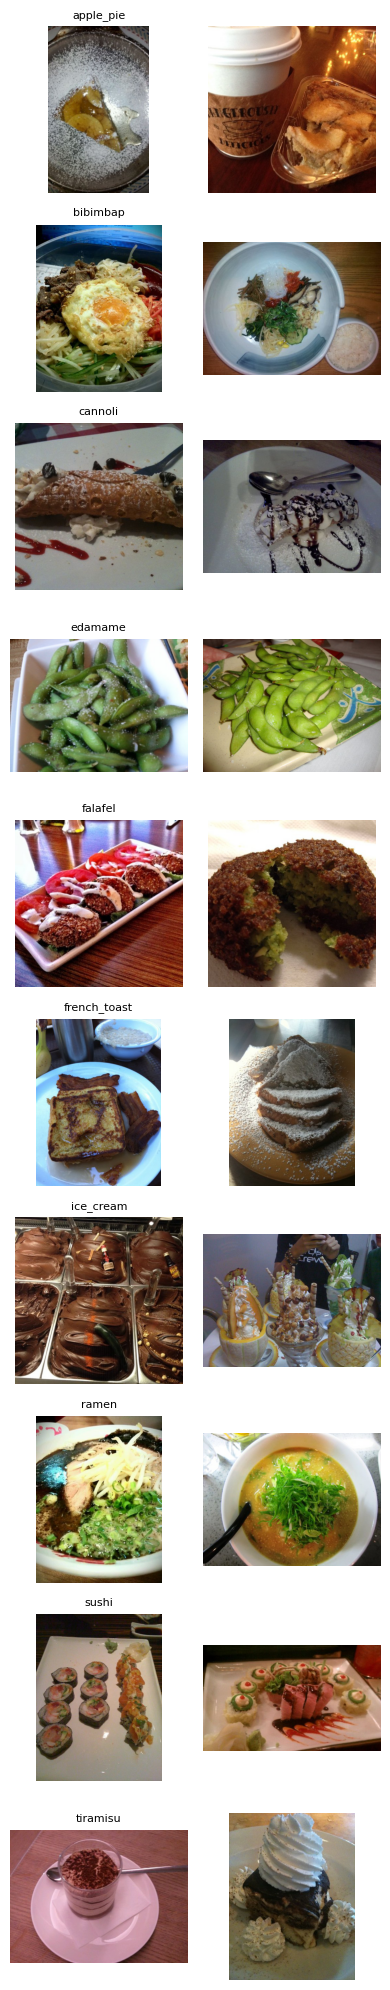

In [ ]:
raw_dataset = datasets.ImageFolder('Data/food-101-tiny/train', transform=transforms.ToTensor())

samples_per_class = 2
class_images = defaultdict(list)

for img, label in raw_dataset:
    if len(class_images[label]) < samples_per_class:
        class_images[label].append(img)
    if all(len(v) == samples_per_class for v in class_images.values()) and len(class_images) == len(raw_dataset.classes):
        break

# set the grid size
num_classes = len(raw_dataset.classes)
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))

for class_idx, imgs in class_images.items():
    for i in range(samples_per_class):
        ax = axes[class_idx, i] if num_classes > 1 else axes[i]
        img = imgs[i].permute(1, 2, 0)
        ax.imshow(img)
        ax.axis("off")
        if i == 0:
            ax.set_title(raw_dataset.classes[class_idx], fontsize=8)

plt.tight_layout()
plt.show()

#### Model architecture (modified vgg16 with DropBlock)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        base = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.dropblock = DropBlock2D(block_size=10, drop_prob=0.3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.dropblock(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

#### Model training

In [30]:
model = Model(num_classes=10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 3

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # === TRAIN ===
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    # === VALIDATION ===
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(test_loader.dataset)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

Epoch 1/25: Train Loss: 2.2776, Train Acc: 16.80%, Val Loss: 2.1418, Val Acc: 34.40%
Epoch 2/25: Train Loss: 2.0737, Train Acc: 29.80%, Val Loss: 1.7783, Val Acc: 53.80%


KeyboardInterrupt: 

Accuracy: 55.60%
              precision    recall  f1-score   support

   apple_pie       0.34      0.62      0.44        50
    bibimbap       0.45      0.78      0.57        50
     cannoli       0.50      0.40      0.44        50
     edamame       0.85      1.00      0.92        50
     falafel       0.76      0.32      0.45        50
french_toast       0.79      0.54      0.64        50
   ice_cream       0.58      0.56      0.57        50
       ramen       0.68      0.52      0.59        50
       sushi       0.47      0.74      0.57        50
    tiramisu       1.00      0.08      0.15        50

    accuracy                           0.56       500
   macro avg       0.64      0.56      0.54       500
weighted avg       0.64      0.56      0.54       500



<Figure size 1000x1000 with 0 Axes>

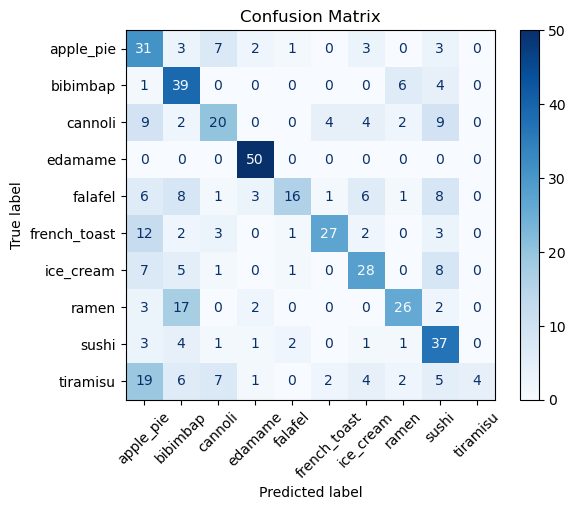

ValueError: x and y must have same first dimension, but have shapes (25,) and (2,)

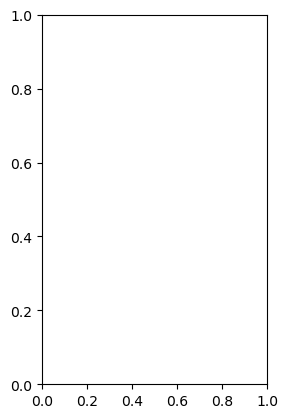

In [31]:
model.eval()
all_preds = []
all_labels = []
epochs = range(1, num_epochs + 1)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Results
print(f'Accuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%')
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Loss throught eopchs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss throught Epochs')
plt.legend()
plt.grid(True)

# Accuracy through epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy throught Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### LICENSE INFO

DropBlock: https://arxiv.org/abs/1810.12890 (amazing paper, I recommend to everyone)